# Transfer learning

![inline](https://github.com/univai-community/cnns_and_tl/blob/main/images/mv2.png?raw=1)

Because the early later structures that make up a dog are the same as the ones that make up furniture, we can use a network trained to distinguish dogs from cats to classify rooms. To do this we take the former model and retrain the later layers of the neural network to combine shapes into furniture rather than animals. The benefit of this technique, called transfer learning, is that because the network has seen so many images of animals, the work of the earlier layers is done. It just needs to see some examples of furniture to make a furniture classifier. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteRPJJMN/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


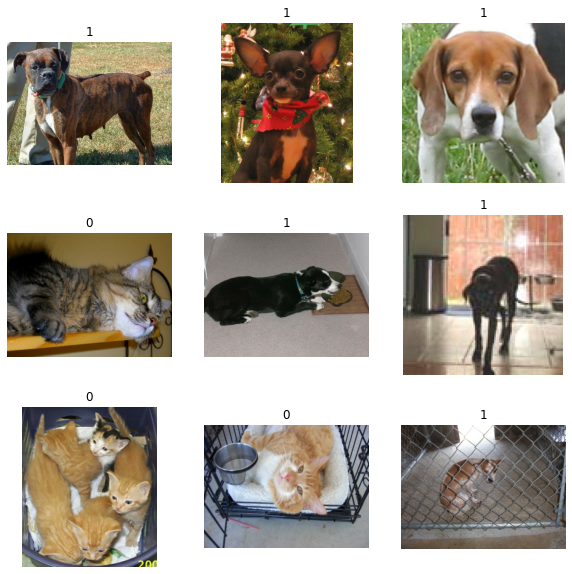

In [3]:
"""
These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


In [4]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


In [5]:
list(train_ds.take(2))[0][0].shape

TensorShape([150, 150, 3])

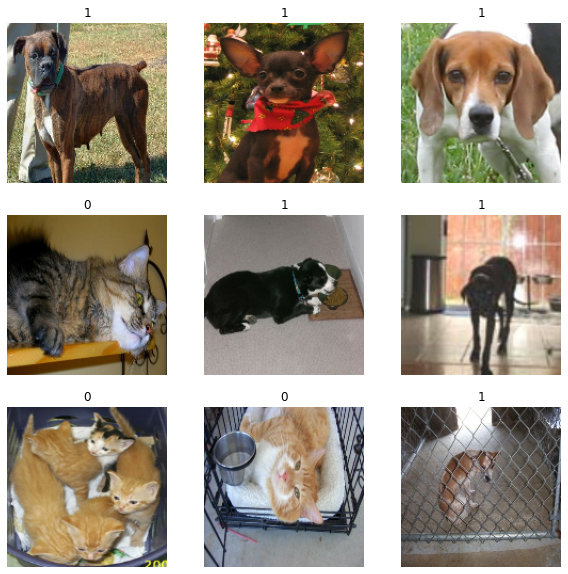

In [6]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.cast(image, 'uint8'))
    plt.title(int(label))
    plt.axis("off")


## Transfer learning workflow

(from the Keras Docs)

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

In general, it's a good practice to develop models that take raw data as input, as opposed to models that take already-preprocessed data. The reason being that, if your model expects preprocessed data, any time you export your model to use it elsewhere (in a web browser, in a mobile app), you'll need to reimplement the exact same preprocessing pipeline. This gets very tricky very quickly. So we should do the least possible amount of preprocessing before hitting the model.

## 1. Start with a pre-trained model and use it to create features: then use a standard classifier

Let us use an existing model and see how it does

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False
) 

83683744/83683744 [==============================] - 3s 0us/step


Here is some deets on Xception: https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202.

The idea started with Inception, whose authors noticed that a dog's face might be big or small in a photo. How do we handle this with same sized convolutional filters?

So they came up with the idea of concatenationg different size filter outputs. They also came up with the idea of doing 1x1 cross channel filters to look at cross-channel correlations.

![](images/inception.png)

Xception is a more expensive idea which makes a much stronger hypothesis than the Inception hypothesis, and assume that cross-channel correlations and spatial correlations can be mapped completely separately?

![](images/intoex.png)

In [8]:
train_ds = train_ds.batch(32)
validation_ds = validation_ds.batch(32)
test_ds = test_ds.batch(32)

```python
inputs = keras.Input(shape=(150, 150, 3))
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
```

In [10]:
def get_features_and_labels(dataset): 
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.xception.preprocess_input(images)
        features = base_model.predict(preprocessed_images) 
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [11]:
train_features, train_labels = get_features_and_labels(train_ds) 
val_features, val_labels = get_features_and_labels(validation_ds) 
test_features, test_labels = get_features_and_labels(test_ds)

1/1 [==============================] - 0s 25ms/step


In [12]:
train_features.shape, train_labels.shape

((9305, 5, 5, 2048), (9305,))

In [30]:
inputs = keras.Input(shape=(5, 5, 2048))
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(inputs) # or Flatten()
x = keras.layers.Dropout(0.15)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [31]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 2048)]      0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-5), 
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [33]:
callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath="feature_extraction.keras",
                save_best_only=True,
                monitor="val_loss")
       ]

In [34]:
history = model.fit(
            train_features, train_labels,
            epochs=20,
            validation_data=(val_features, val_labels),
            callbacks=callbacks)

Epoch 1/20
291/291 [==============================] - 2s 7ms/step - loss: 0.5831 - binary_accuracy: 0.6605 - val_loss: 0.4008 - val_binary_accuracy: 0.8018
Epoch 2/20
291/291 [==============================] - 2s 5ms/step - loss: 0.3218 - binary_accuracy: 0.8685 - val_loss: 0.2618 - val_binary_accuracy: 0.9170
Epoch 3/20
291/291 [==============================] - 2s 6ms/step - loss: 0.2263 - binary_accuracy: 0.9267 - val_loss: 0.2019 - val_binary_accuracy: 0.9407
Epoch 4/20
291/291 [==============================] - 2s 6ms/step - loss: 0.1813 - binary_accuracy: 0.9404 - val_loss: 0.1695 - val_binary_accuracy: 0.9467
Epoch 5/20
291/291 [==============================] - 2s 5ms/step - loss: 0.1542 - binary_accuracy: 0.9508 - val_loss: 0.1495 - val_binary_accuracy: 0.9527
Epoch 6/20
291/291 [==============================] - 2s 5ms/step - loss: 0.1371 - binary_accuracy: 0.9555 - val_loss: 0.1361 - val_binary_accuracy: 0.9570
Epoch 7/20
291/291 [==============================] - 2s 6ms/ste

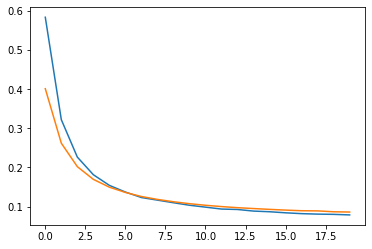

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

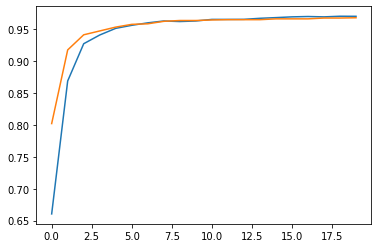

In [36]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

In [37]:
test_model = keras.models.load_model("feature_extraction.keras")
test_results = test_model.predict(test_features)
test_preds = 1*(test_results >= 0)
from sklearn.metrics import accuracy_score
print(f"Test accuracy: {accuracy_score(test_labels, test_preds):.3f}")

73/73 [==============================] - 0s 3ms/step
Test accuracy: 0.969


### One shot learning on your iphone

![inline](https://github.com/univai-community/cnns_and_tl/blob/main/images/mv3.png?raw=1)

Apple’s Face Id works by computing the output of the later layers of a neural network after seeing your image. We call this your embedding. When you try and get into your phone later, it re-performs inference on your new photo. If your new embedding is similar to your old one, it lets you in. Image from Valigi and Mauro (2020).

## 2. Training a new model with low data: Data augmentation

In low data situations, we need to regularize, if we are not going to choose simpler models. How do we do this?

One way is to artificially inflate the data. This is a very powerful concept called **Data Augmentation**

In [118]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

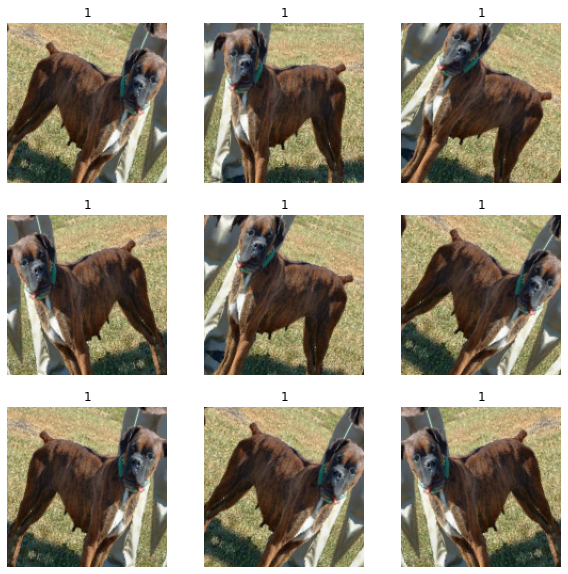

In [119]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## 3. Let us train a fresh model by replacing the old model's head

![](images/newhead.png)

We replace the head of the exception classifier with our own head, created to solve OUR classification problem. We freeze the weights of the Xception model and train the new weights. This ensures that all the hard work we did (or rather someone else did) in learning visual features is not lost.

In [202]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False
)  # Do not include the ImageNet classifier at the top.

![](images/xceptionarch.png)

In [203]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_30[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [204]:
base_model.trainable = False

In [205]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_30[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [206]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be normalized
x = keras.applications.xception.preprocess_input(x)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.Flatten()(x)
x = keras.layers.GlobalAvgPool2D()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.4)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [207]:
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_18 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_18 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_18  (None, 2048)             0  

In [208]:
model.compile(optimizer=keras.optimizers.Adam(3e-05),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [209]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [210]:
epochs = 20
history = model.fit(train_ds, 
    epochs=epochs, 
    validation_data=validation_ds,
    callbacks = callbacks)

Epoch 1/20
291/291 [==============================] - 32s 100ms/step - loss: 0.2807 - binary_accuracy: 0.8699 - val_loss: 0.1003 - val_binary_accuracy: 0.9630
Epoch 2/20
291/291 [==============================] - 28s 96ms/step - loss: 0.1510 - binary_accuracy: 0.9354 - val_loss: 0.0855 - val_binary_accuracy: 0.9665
Epoch 3/20
291/291 [==============================] - 28s 97ms/step - loss: 0.1368 - binary_accuracy: 0.9433 - val_loss: 0.0833 - val_binary_accuracy: 0.9686
Epoch 4/20
291/291 [==============================] - 29s 98ms/step - loss: 0.1272 - binary_accuracy: 0.9464 - val_loss: 0.0804 - val_binary_accuracy: 0.9695
Epoch 5/20
291/291 [==============================] - 28s 95ms/step - loss: 0.1204 - binary_accuracy: 0.9498 - val_loss: 0.0797 - val_binary_accuracy: 0.9703
Epoch 6/20
291/291 [==============================] - 28s 95ms/step - loss: 0.1160 - binary_accuracy: 0.9528 - val_loss: 0.0747 - val_binary_accuracy: 0.9699
Epoch 7/20
291/291 [==============================]

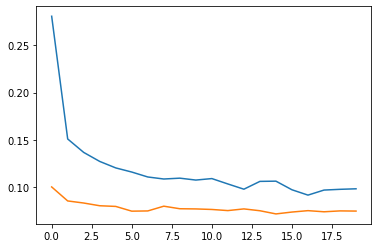

In [211]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

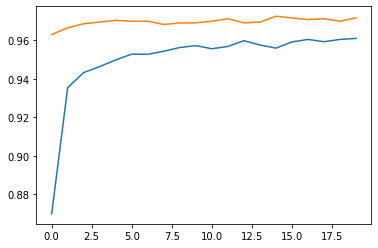

In [212]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

In [213]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

73/73 [==============================] - 5s 61ms/step - loss: 0.0732 - binary_accuracy: 0.9712
Test accuracy: 0.971


## 4. Now unfreezing more than just the top

Now remember we have to make the differing eyes, drooping vs not drooping ears, and all that for the dogs and cats. Perhaps some of this can be done in the last convolutional layers. We unfreeze the last block of the xception model.

Here is what it conceptually looks like, illustrated on a vgg16 model.

![](images/unfreeze.png)

In [214]:
base_model.layers

In [215]:
base_model.layers[-6:]

From the Keras docs: 

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [216]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
for layer in base_model.layers[:-6]:
    layer.trainable = False
model.summary()


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_18 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_18 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_18  (None, 2048)             0  

In [217]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="finetuned.keras",
        save_best_only=True,
        monitor="val_loss")
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history2 = model.fit(train_ds, 
    epochs=epochs, 
    validation_data=validation_ds,
    callbacks = callbacks)

Epoch 1/10
291/291 [==============================] - 34s 108ms/step - loss: 0.0900 - binary_accuracy: 0.9617 - val_loss: 0.0697 - val_binary_accuracy: 0.9725
Epoch 2/10
291/291 [==============================] - 30s 104ms/step - loss: 0.0867 - binary_accuracy: 0.9627 - val_loss: 0.0684 - val_binary_accuracy: 0.9729
Epoch 3/10
291/291 [==============================] - 30s 104ms/step - loss: 0.0813 - binary_accuracy: 0.9671 - val_loss: 0.0680 - val_binary_accuracy: 0.9733
Epoch 4/10
291/291 [==============================] - 30s 102ms/step - loss: 0.0750 - binary_accuracy: 0.9685 - val_loss: 0.0711 - val_binary_accuracy: 0.9729
Epoch 5/10
291/291 [==============================] - 31s 106ms/step - loss: 0.0728 - binary_accuracy: 0.9702 - val_loss: 0.0653 - val_binary_accuracy: 0.9742
Epoch 6/10
291/291 [==============================] - 30s 102ms/step - loss: 0.0714 - binary_accuracy: 0.9715 - val_loss: 0.0673 - val_binary_accuracy: 0.9746
Epoch 7/10
291/291 [==========================

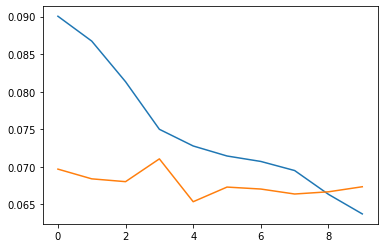

In [218]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

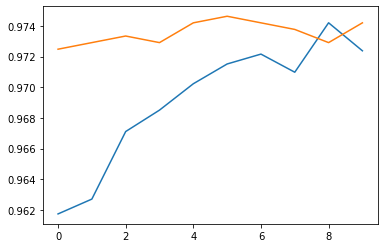

In [219]:
plt.plot(history2.history['binary_accuracy'])
plt.plot(history2.history['val_binary_accuracy'])

In [220]:
test_model = keras.models.load_model("finetuned.keras") 
test_loss, test_acc = model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

73/73 [==============================] - 5s 62ms/step - loss: 0.0705 - binary_accuracy: 0.9729
Test accuracy: 0.973


## 5. Unfreeze everything!

This is the particularization part: perhaps we can eke out a bit more fermormance by letting the lower layers change to just deal with cats and dogs!

In [221]:
base_model.trainable = True
for layer in base_model.layers[:-6]:
    layer.trainable = True
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_18 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_18 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_18  (None, 2048)             0  

In [222]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="finetuned_all.keras",
        save_best_only=True,
        monitor="val_loss")
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history3 = model.fit(train_ds, 
    epochs=epochs, 
    validation_data=validation_ds,
    callbacks = callbacks)

Epoch 1/10
291/291 [==============================] - 105s 347ms/step - loss: 0.0547 - binary_accuracy: 0.9785 - val_loss: 0.0539 - val_binary_accuracy: 0.9785
Epoch 2/10
291/291 [==============================] - 100s 345ms/step - loss: 0.0467 - binary_accuracy: 0.9817 - val_loss: 0.0498 - val_binary_accuracy: 0.9807
Epoch 3/10
291/291 [==============================] - 100s 344ms/step - loss: 0.0350 - binary_accuracy: 0.9865 - val_loss: 0.0476 - val_binary_accuracy: 0.9785
Epoch 4/10
291/291 [==============================] - 99s 341ms/step - loss: 0.0269 - binary_accuracy: 0.9898 - val_loss: 0.0538 - val_binary_accuracy: 0.9807
Epoch 5/10
291/291 [==============================] - 99s 342ms/step - loss: 0.0250 - binary_accuracy: 0.9902 - val_loss: 0.0574 - val_binary_accuracy: 0.9789
Epoch 6/10
291/291 [==============================] - 99s 341ms/step - loss: 0.0212 - binary_accuracy: 0.9922 - val_loss: 0.0536 - val_binary_accuracy: 0.9815
Epoch 7/10
291/291 [=======================

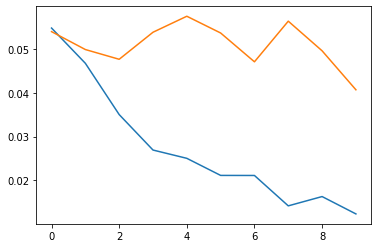

In [223]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

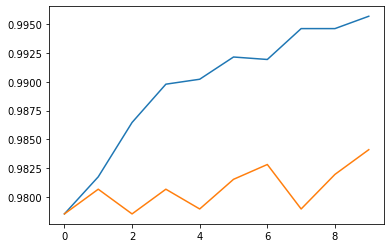

In [224]:
plt.plot(history3.history['binary_accuracy'])
plt.plot(history3.history['val_binary_accuracy'])

In [225]:
test_model = keras.models.load_model("finetuned_all.keras") 
test_loss, test_acc = model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

73/73 [==============================] - 5s 61ms/step - loss: 0.0800 - binary_accuracy: 0.9764
Test accuracy: 0.976


![inline](https://github.com/univai-community/cnns_and_tl/blob/main/images/mv4.png?raw=1)

Imagine you are looking at legal documents, or contracts. The number of contracts you have access to are likely to be smaller than the size of reddit or wikipedia. But by training your initial model on the larger Reddit and wikipedia, and then transferring to your smaller contract data, you can particularize domain specific embeddings from the more general ones. The models trained on the bigger data pick up basic vocabulary and grammar, which are useful for pretty much everything and now you can make them specific to your domain: insurance claims or EMR notes or contracts.
